## Local Reality and the CHSH Inequality

In 1963, John Stewart Bell published what could be argued as one of the most profound discoveries in the history of science. Bell stated that any theory invoking local hidden variables could be experimentally ruled out. 

## The Nobel Prize in Physics 2022

John F. Clauser

Born: 1 December 1942, Pasadena, CA, USA

Affiliation at the time of the award: J.F. Clauser & Assoc., Walnut Creek, CA, USA

Prize motivation: “for experiments with entangled photons, establishing the violation of Bell inequalities and pioneering quantum information science”

https://www.nobelprize.org/prizes/physics/2022/clauser/facts/

## The CHSH inequality 

Imagine Alice and Bob are given each one part of a bipartite entangled system. Each of them then performs two measurements on their part in two different bases. Let's call Alice's bases A and a and Bob's B and b. What is the expectation value of the quantity ?

$$\langle CHSH \rangle =\langle AB\rangle -\langle Ab\rangle +\langle aB\rangle +\langle ab \rangle$$

Now, Alice and Bob have one qubit each, so any measurement they perform on their system (qubit) can only yield one of two possible outcomes: +1 or -1. Note that whereas we typically refer to the two qubit states as $|0\rangle $ and $|1\rangle$, these are eigenstates, and a projective measurement will yield their eigenvalues, +1 and -1, respectively.

Therefore, if any measurement of $A$, $a$, $B$, and $b$ can only yield $\pm 1$, the quanttities $(B-b)$ and $(B+b)$ can only be 0 or $\pm 2$. And thus, the quantity $A(B-b)+a(B+b)$ can only be either +2 or -2, which means that there should be a bound for the expectation value of the quantity we have called

$$|\langle CHSH \rangle| = |\langle AB\rangle -\langle Ab\rangle +\langle aB\rangle +\langle ab\rangle|\le 2$$

Now, the above discussion is oversimplified, because we could consider that the outcome on any set of measurements from Alice and Bob could depend on a set of local hidden variables, but it can be shown with some math that, even when that is the case, the expectation value of the quantity $CHSH$ should be bounded by 2 if local realism held.

### But what happens when we do these experiments with an <span style="color: red; ">entangled</span> system?

In [1]:
# import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

# import python stuff 
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
backend = Aer.get_backend('aer_simulator')

First we are going to define a function to create CHSH circuits. We are going to choose, witout loss of generality, 
that Bob always uses the computational $\langle Z \rangle$ and the $X$ bases for his $B$ and $b$ measurements, respectively, whereas Alice chooses also orthogonal bases but whose angle we are going to vary between 0 and $2\pi$ with respect to Bob's bases. This set of angles is going to be the input argument to our $CHSH$ circuit building function.

In [3]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

Next, we are going to define a function for estimating the quantity $\langle CHSH\rangle$. One can define 
two of such quantities, actually, $\langle CHSH1 \rangle =\langle AB\rangle - \langle Ab \rangle + \langle aB\rangle +\langle ab\rangle$ and $\langle CHSH2 \rangle =\langle AB\rangle + \langle Ab \rangle - \langle aB\rangle +\langle ab\rangle$. Once chosen the corresponding measurement axes for both parties, each expectation value can be simply estimated by adding the counts from the output bitstrings with the appropriate sign (plus for the even terms 00 and 11 and minus for odd terms 01 and 10.)

In [4]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

Finally, we are going to split the interval [0,$2\pi$) into 15 angles and will build the corresponding set of $CHSH$ circuits.

In [5]:
number_of_thetas = 15
theta_vec = np.linspace(0, 2*np.pi, number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

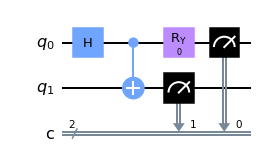

In [6]:
my_chsh_circuits[0].draw('mpl')

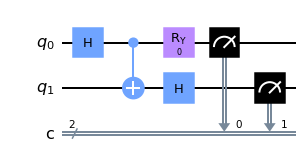

In [7]:
my_chsh_circuits[1].draw('mpl')

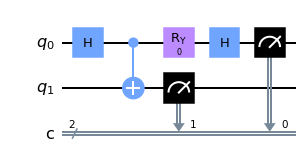

In [8]:
my_chsh_circuits[2].draw('mpl')

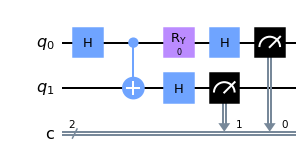

In [9]:
my_chsh_circuits[3].draw('mpl')

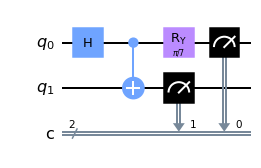

In [10]:
my_chsh_circuits[4].draw('mpl')

These circuits are simply creating a Bell pair, and then measuring each party in a different basis. While Bob ($q_1$) always measures either in the computational basis or the $X$ basis, Alices's measurement basis rotates by the angle $\theta$ with respect to Bob's. 

In [11]:
# Excecute ant get counts
result_ideal = backend.run(my_chsh_circuits).result()

#tic = time.time()
#transpiled_circuits = transpile(my_chsh_circuits, quito)
#job_real = quito.run(transpiled_circuits, shots=8192)
#job_monitor(job_real)
#result_real = job_real.result()
#toc = time.time()

#print(toc-tic)

In [12]:
# check result_ideal
counts = result_ideal.get_counts()
    
for i in range(0, len(counts), 4):  
    theta_dict = counts[i:i + 4]
    zz = theta_dict[0]
    zx = theta_dict[1]
    xz = theta_dict[2]
    xx = theta_dict[3]
    no_shots = sum(xx[y] for y in xx)

In [13]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
#CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

Now we plot the results.

Text(0, 0.5, 'CHSH witness')

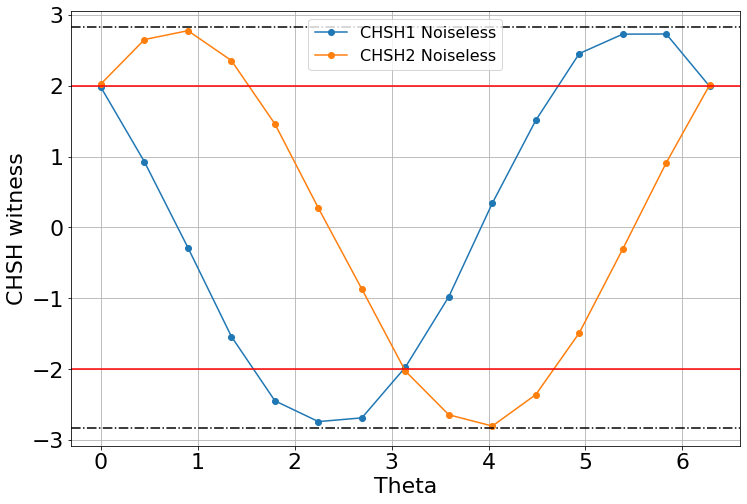

In [14]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

#plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quito')
#plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quito')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

Note what happend! These are some particular combination of measurement bases for which $|CHSH|>2$!. How is this possible? Let's look at our entangled bipartite system. It is easy to show that if $|\psi\rangle=\frac{1}{\sqrt{2}}|00\rangle + |11\rangle)$, then the expectation value $\langle AB \rangle =\langle \psi|A\otimes B|\psi\rangle=-\cos\theta_{AB}$ where $\theta_{AB}$ is the angle between the measurement bases $A$ and $B$. Therefore, for the particular choice of bases $A=\frac{1}{\sqrt{2}}(\sigma_z - \sigma_x)$ and $a=\frac{1}{\sqrt{2}}(\sigma_z + \sigma_x)$, letting Bob measure with $B=\sigma_z$ and $b=\sigma_x$, we see that $|\langle CHSH1\rangle|=2\sqrt{2}>2$. It can also be shown that $2\sqrt{2}$ is the maximum possible value attainable, even in the quantum case.

The above inequality is called CHSH after Clauser, Horne, Shimony, and Holt, and it is the most popular way of presenting the original inequality from Bell.

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table